In [1]:
import torch
import transformers
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import os
import pprint
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [2]:
# Device and paths:
device = 'cuda'
physionet_dir = '/datasets/work/hb-mlaifsp-mm/work/archive/physionet.org/files'
dataset_dir = '/scratch3/nic261/datasets'
database_path = '/scratch3/nic261/database/cxrmated_test.db'
mimic_cxr_jpg_dir = '/scratch3/nic261/datasets/physionet.org/files/mimic-cxr-jpg/2.0.0/files'

In [3]:
# Download model checkpoint:
model = transformers.AutoModel.from_pretrained('aehrc/cxrmate-ed', trust_remote_code=True).to(device=device)
model.eval()

# Download tokenizer:
tokenizer = transformers.PreTrainedTokenizerFast.from_pretrained('aehrc/cxrmate-ed')
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

/scratch3/nic261/environments/cxrmate2-virga-venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/scratch3/nic261/environments/cxrmate2-virga-venv/lib/python3.12/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/scratch3/nic261/environments/cxrmate2-virga-venv/lib/python3.12/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/scratch3/nic261/environments/cxrmate2-virga-venv/lib/python3.12/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy

In [4]:
# Image transforms:
image_size = 384
test_transforms = v2.Compose(
    [
        v2.Grayscale(num_output_channels=3),
        v2.Resize(
            size=image_size, 
            antialias=True,
            interpolation=v2.InterpolationMode.BICUBIC,
        ),
        v2.CenterCrop(size=[image_size, image_size]),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ]
)

In [5]:
# Prepare the MIMIC-CXR & MIMIC-IV-ED dataset:
model.prepare_data(
    physionet_dir=physionet_dir,
    dataset_dir=dataset_dir,
    database_path=database_path,
)

# Get the test set dataset & dataloader:
test_set = model.get_dataset('test', test_transforms, database_path, mimic_cxr_jpg_dir)
test_dataloader = DataLoader(
    test_set,
    batch_size=1, 
    num_workers=5,
    shuffle=True,
    collate_fn=model.collate_fn,
    pin_memory=True,
)

No. of examples: 1624.
No. of training dicom_ids, study_ids, & subject_ids: 2872, 1624, & 280.


In [6]:
# Get an example:
batch = next(iter(test_dataloader))
        
# Show the batch:
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(batch)

{ 'edstays_index_value_feats': tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 1.]]]),
  'edstays_index_value_mask': tensor([[1]], dtype=torch.int32),
  'edstays_index_value_time_delta': tensor([[[0.7286]]]),
  'edstays_index_value_token_type_ids': tensor([[1]]),
  'findings': [ 'Frontal and lateral views of the chest are obtained. Left '
                "hilar/perihilar opacity corresponds to patient's known "
                'perihilar mass, better assessed on CT. Old-appearing rib '
                'deformities on the left may relate to prior fractures, '
                'metastatic disease not excluded, although better evaluated on '
                'CT. Extensive vascular calcification is seen projecting over '
                'the upper hemithorax bilaterally. No new focal consolidation, '
                'pleural effusion, or evidence of pneum

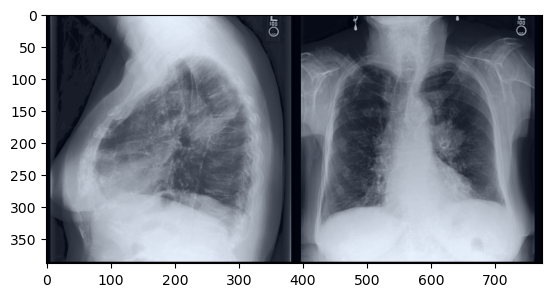

In [7]:
# Show the images for the study:
plt.imshow(make_grid(batch['images'][0], normalize=True).permute(1, 2, 0))

In [8]:
# Move tensors in the batch to the device:
for key, value in batch.items():
    if isinstance(value, torch.Tensor):
        batch[key] = value.to(device)

In [9]:
# Convert the patient data in the batch into embeddings:
inputs_embeds, attention_mask, token_type_ids, position_ids, bos_token_ids = model.prepare_inputs(tokenizer=tokenizer, **batch)
    
# Generate reports:
output_ids = model.generate(
    input_ids=bos_token_ids,
    decoder_inputs_embeds=inputs_embeds,
    decoder_token_type_ids=token_type_ids,
    prompt_attention_mask=attention_mask,
    prompt_position_ids=position_ids,
    special_token_ids=[tokenizer.sep_token_id],
    token_type_id_sections=model.decoder.config.section_ids,
    max_length=256,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    num_beams=4,
    return_dict_in_generate=True,
    use_cache=True,
)['sequences']


In [10]:
# Findings and impression section:
findings, impression = model.split_and_decode_sections(output_ids, [tokenizer.sep_token_id, tokenizer.eos_token_id], tokenizer)
for i,j in zip(findings, impression):
    print(f'Findings:\t{i}\nImpression:\t{j}\n\n')

Findings:	PA and lateral views of the chest. There is a consolidation in the left upper lobe concerning for scarring. There is scarring in the left upper lobe. There is scarring in the right upper lobe. No pleural effusion or pneumothorax is seen. The lungs are hyperinflated. The cardiomediastinal and hilar contours are stable. No definite bony abnormality is seen. Old left-sided rib deformities are seen.
Impression:	Left upper lobe consolidation compatible with scarring.


